# Profiling example

Data generated in `./examples/quick_Pprofile.R`.

Note these are statistics of exceedance probabilities $P(X > xthresh)$, not log probabilities.

All CIs are at level $\alpha = 0.01$, meaning the confidence interval is given by the $0.005$ and $0.995$ empirical quantiles of a single bootstrapped run. Each bootstrap run draws 400 samples with replacement of the same size as the data.

- Each row in `d` has results from an **independent run** of the bootstrapped procedure.
- e.g. `qlow` for a given row is the bootstrapped lower confidence bound given by the $0.005$-th empirical quantile for a single bootstrap run
- This is done for each run and each parameter set of `(scale1, scale2, s, loc1, loc2, xthresh)`.

### Next steps for validation

Once we are comfortable with *how* to validate these confidence intervals, I will add some validation functions to the file `mf_boot_estimation.R`.

Also, this example does not currently compare these results to those gotten by using the high-fidelity data only.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
d = pd.read_csv('data/quick_Pprofile_est.csv')
dtrue = pd.read_csv('data/quick_Pprofile_true.csv')

In [3]:
d.describe()

runid        parid       qhf_005       qhf_995         q_005  \
count  8800.000000  8800.000000  8.800000e+03  8.800000e+03  8.800000e+03   
mean    100.500000    22.500000  1.118993e-04  6.192004e-04  1.408452e-04   
std      57.737586    12.699147  1.925501e-04  9.589947e-04  2.408605e-04   
min       1.000000     1.000000  6.876306e-09  4.572859e-07  0.000000e+00   
25%      50.750000    11.750000  5.997403e-07  1.202740e-05  3.626034e-07   
50%     100.500000    22.500000  7.856207e-06  9.168572e-05  5.315261e-06   
75%     150.250000    33.250000  1.094328e-04  7.753900e-04  7.280994e-05   
max     200.000000    44.000000  1.274719e-03  5.006034e-03  1.411718e-03   

              q_995  
count  8.800000e+03  
mean   4.840561e-04  
std    7.446986e-04  
min    5.821577e-07  
25%    9.258663e-06  
50%    8.517034e-05  
75%    7.155441e-04  
max    5.080857e-03

In [4]:
d.head()

runid  parid   qhf_005   qhf_995     q_005     q_995
0      1      1  0.000213  0.001708  0.000236  0.002247
1      2      1  0.000191  0.001247  0.000269  0.001969
2      3      1  0.000200  0.001332  0.000000  0.000961
3      4      1  0.000253  0.001315  0.000203  0.002005
4      5      1  0.000387  0.002221  0.000012  0.002490

In [5]:
dtrue.describe()

scale1  scale2          s  loc1  loc2    xthresh     p_true
count    44.0    44.0  44.000000  44.0  44.0  44.000000  44.000000
mean      1.0     1.0  26.000000   0.0   0.0  10.361494   0.000278
std       0.0     0.0  15.994185   0.0   0.0   2.604306   0.000424
min       1.0     1.0   1.000000   0.0   0.0   6.907255   0.000001
25%       1.0     1.0  11.000000   0.0   0.0   8.634532   0.000008
50%       1.0     1.0  26.000000   0.0   0.0  10.361605   0.000055
75%       1.0     1.0  41.000000   0.0   0.0  12.088568   0.000325
max       1.0     1.0  51.000000   0.0   0.0  13.815510   0.001000

In [6]:
# will match with index, so need parid-1
d['parid'] = d['parid']-1

In [7]:
d = d.merge(dtrue, how = 'left', left_on = 'parid', right_index = True)

### Data transformations

Each data point here is an **independent run** of the bootstrapped procedure.

Assuming low CI bound identifier leads with zero and high leads with 9.

In [8]:
d.columns = d.columns.str.replace(r'q(hf)?_0\d+', 'q\g<1>low')
d.columns = d.columns.str.replace(r'q(hf)?_9\d+', 'q\g<1>high')

In [9]:
d = d.assign(ci_cover_hi = d.p_true.le(d.qhigh), 
             ci_cover_lo = d.p_true.ge(d.qlow), 
             ci_cover = lambda x: x.loc[:, 'ci_cover_hi':].all(axis = 1), 
             ci_width = d.qhigh - d.qlow,
             hfci_cover_hi = d.p_true.le(d.qhfhigh), 
             hfci_cover_lo = d.p_true.ge(d.qhflow), 
             hfci_cover = lambda x: x.loc[:, 'hfci_cover_hi':].all(axis = 1), 
             hfci_width = d.qhfhigh - d.qhflow)

## How well does the bootstrapped CI cover the true value?

### Univariate: Summary
A summary across all `xthresh` values.

In [10]:
dcover = d.loc[:, ['s', 'xthresh', 'ci_cover', 'ci_width', 'hfci_cover', 'hfci_width']]
dcover = dcover.groupby(['s', 'xthresh']).agg('mean').reset_index()

In [11]:
dcover.describe()

s    xthresh   ci_cover   ci_width  hfci_cover  hfci_width
count  44.000000  44.000000  44.000000  44.000000   44.000000   44.000000
mean   26.000000  10.361494   0.986818   0.000343    0.981250    0.000507
std    15.994185   2.604306   0.009092   0.000533    0.008567    0.000729
min     1.000000   6.907255   0.960000   0.000002    0.965000    0.000004
25%    11.000000   8.634532   0.980000   0.000015    0.975000    0.000025
50%    26.000000  10.361605   0.990000   0.000089    0.982500    0.000134
75%    41.000000  12.088568   0.995000   0.000482    0.986250    0.000621
max    51.000000  13.815510   1.000000   0.002357    0.995000    0.001790

### Univariate: Plots

#### CI coverage rates across runs

Take away here is that *for highly rare event probabilities*, when `s = 1/dep >= 10`

- multifidelity CI coverage probability approximately achieves the correct 0.99 coverage probability
- with a smaller CI width

The difference is not too stark here, at least in coverage probability, and this does not include the additional step needed in multifidelity estimation when the hifi and lofi models are at different scales. 

In [12]:
dcover = dcover.melt(id_vars = ['s', 'xthresh'])

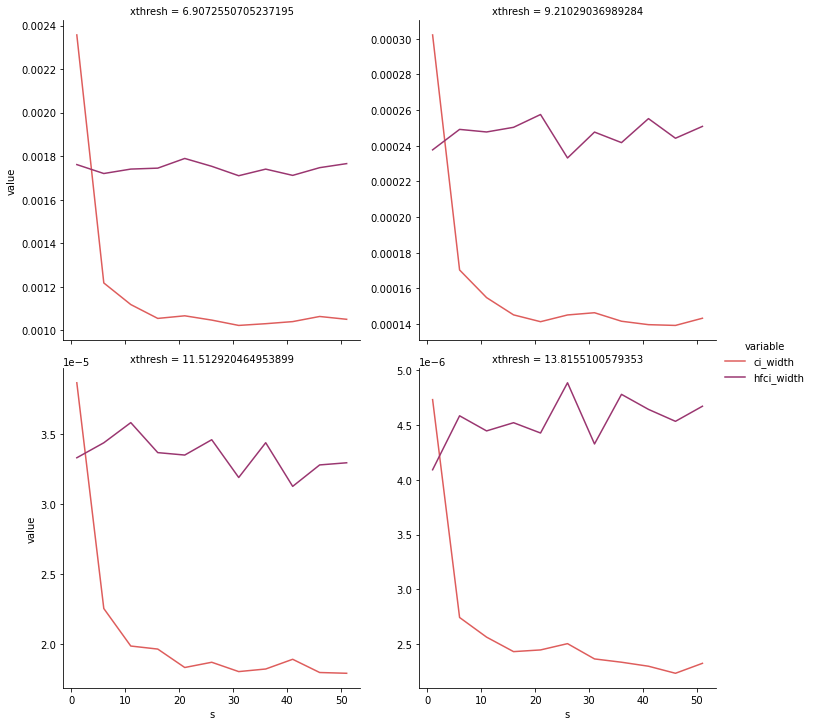

In [13]:
sns.relplot(data = dcover.loc[dcover.variable.str.match('(hf)?ci_width')],
            x = 's', y = 'value', kind = 'line',
            hue = 'variable', col = 'xthresh', col_wrap = 2,
            facet_kws = dict(sharey = False),
           palette = sns.color_palette("flare", n_colors = 2))

plt.show()

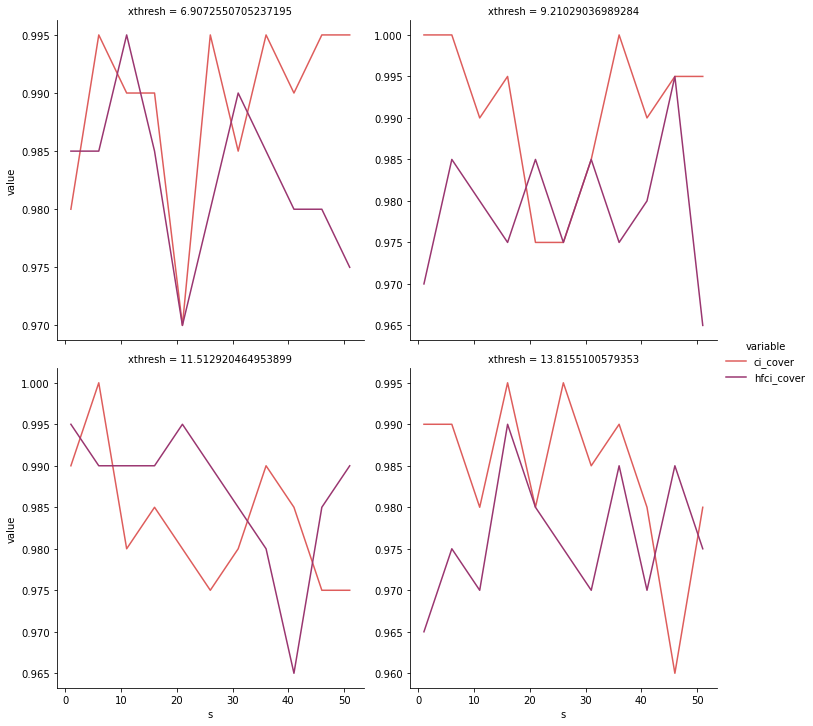

In [14]:
sns.relplot(data = dcover.loc[dcover.variable.str.match('(hf)?ci_cover')],
            x = 's', y = 'value', kind = 'line',
            hue = 'variable', col = 'xthresh', col_wrap = 2,
            facet_kws = dict(sharey = False),
           palette = sns.color_palette("flare", n_colors = 2))

plt.show()

### Another way to look at it.
seaborn computes the mean values (in this case *of the quantile estimates*) for bootrapped resamples *of this dataset*. See [EstimateAggregator](https://github.com/mwaskom/seaborn/blob/master/seaborn/_statistics.py)

Error bars show these quantiles.

**Shows that the 'bootstrapped CIs are correct on average'**

- in most scenarios, 99 percent of the 200 bootstrapped confidence intervals **for the mean qlow/qhigh** cover the true value
- with some exceptions, $s = 30, 40$ for the smallest `xthresh`
- this is **as it should be** since the confidence intervals are at level $\alpha = 0.01$
- clearly not the narrowest CI possible for small `s` values

Note the different y-axis scales.

In [15]:
d_long = d.loc[:, ['s', 'xthresh', 'runid', 'ci_cover', 'qlow', 'qhigh', 'p_true']]
d_long = d_long.melt(id_vars = ['s', 'xthresh', 'runid', 'ci_cover'])
d_long['xthresh'] = np.round(d_long['xthresh'], 2)

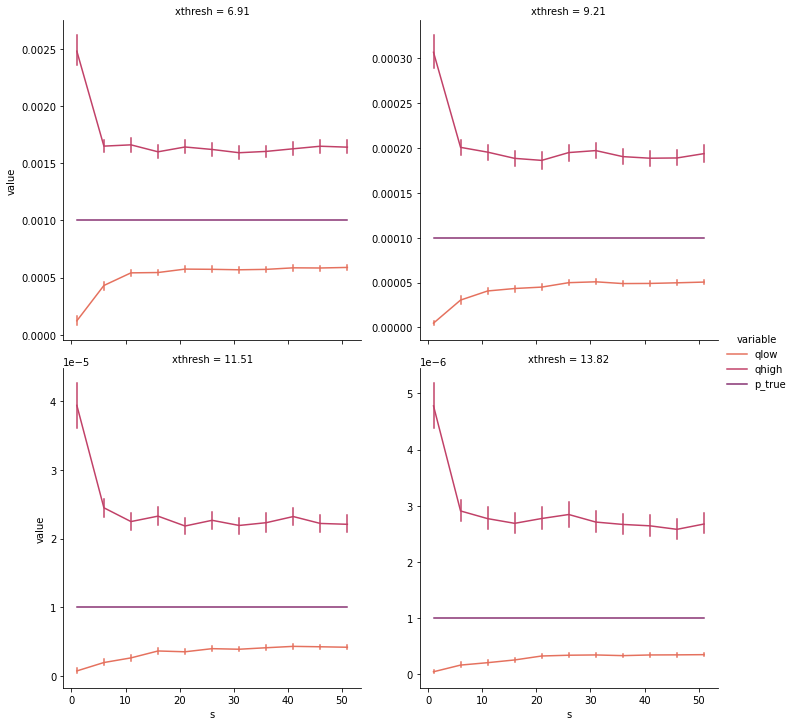

In [16]:
sns.relplot(data = d_long, col_wrap = 2, kind = 'line',
            x = 's', y = 'value', hue = 'variable', col = 'xthresh',
            ci = 99, err_style = 'bars',
            facet_kws = dict(sharey = False),
            palette = sns.color_palette("flare", n_colors = 3))
plt.show()

#### Final note 
This `double boostrap` method also worked well in the case when the lofi estimate (`phat` in the explanation above) was *not* bootstrapped and only the variability of the difference term `diffp` was used to estimate confidence intervals.